In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/MA')
print(os.listdir(os.getcwd()))
import json
import pandas as pd
import gzip
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['SIG Proceedings Template-Jan2015 Zip', '.DS_Store', 'we_data.zip', 'sig-proceedings-template-may2015-zip.zip', 'click_predictions', 'bid_predictions', 'payprice_predictions', 'Click Prediction Grid Search.gsheet', 'Payprice_Prediction.ipynb', 'Preprocessing1.ipynb', 'CTR Prediction.ipynb', 'data2', 'data', 'League_of_Agents.ipynb', 'MA_Feature_Engineering.ipynb']


In [0]:
folder='data2/'
data=pd.read_csv(folder+'train1'+'.csv',dtype={'slotvisibility':str,'slotformat':str,'creative':str,'slotid2':str})

In [12]:
data.columns

Index(['click', 'weekday', 'hour', 'bidid', 'userid', 'useragent', 'IP',
       'region', 'city', 'adexchange', 'domain', 'url', 'urlid', 'slotid',
       'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice',
       'creative', 'bidprice', 'payprice', 'keypage', 'advertiser', 'usertag'],
      dtype='object')

In [17]:
np.count_nonzero(data.adexchange==4)/2430981

0.032906468623160774

In [0]:
data['new']=''
for i in range(len(data)):
  if not data.at[i,'slotformat']=='Na':
    data.at[i,'new']=data.at[i,'slotformat']+' '+data.at[i,'slotvisibility']
  else:
    data.at[i,'new']=data.at[i,'slotvisibility']
print(len(set(data.new)))
print(sorted(list(set(data.new))))

16
['0 0', '0 1', '0 2', '1 0', '1 1', '1 2', '1 255', '5 0', '5 1', 'FifthView', 'FirstView', 'FourthView', 'Na', 'OtherView', 'SecondView', 'ThirdView']


In [0]:
def basic_EDA(data):
  print('\t\t'.join(['field name','#int','#float','#string','#bool','#nan','#total','#unique','examples']))
  for column in data.columns:
    s=data[column]
    Int=0
    Float=0
    String=0
    Nan=0
    Bool=0
    for n in s:
      if isinstance(n,str):
        String+=1
      elif np.isnan(n):
        Nan+=1
      elif isinstance(n,bool):
        Bool+=1
      elif isinstance(n,int):
        Int+=1
      elif isinstance(n,float):
        Float+=1
    if Nan==len(s):
      Unique=-1
      Examples=''
    else:
      s=sorted(list(set([n for n in s if isinstance(n,str) or not np.isnan(n)])))
      Unique=len(s)
      Examples='|'.join([str(s[i]) for i in range(min(Unique,30))])
    column+=''.join([' ' for i in range(14-len(column))])
    print('\t\t'.join([column,str(Int),str(Float),str(String),str(Bool),str(Nan),str(Int+Float+String+Bool+Nan),str(Unique),Examples]))
    
def cooccurence_matrix(data,field1,field2):
  dic1=dict.fromkeys(sorted(list(set(data[field1]))))
  dic2=dict.fromkeys(sorted(list(set(data[field2]))))
  i=0
  for key in dic1.keys():
    dic1[key]=i
    i+=1
  j=0
  for key in dic2.keys():
    dic2[key]=j
    j+=1
  co=np.zeros([i,j]).astype(int)
  for k in range(len(data)):
    co[dic1[data.at[k,field1]],dic2[data.at[k,field2]]]+=1
  print(field1,'has',i,'unique instances')
  print(field2,'has',j,'unique instances')
  return co

In [0]:
def plot_frequency(counts,field_name,valid_counts_index):
  plt.figure()
  plt.rcParams.update({'font.size': 18})
  plt.grid(None)
  plt.bar(range(len(counts)),counts)
  plt.xticks(range(len(counts)),[str(i) for i in valid_counts_index])
  plt.xlabel('No. of instance occurence')
  plt.ylabel('Frequency')
  plt.title('Feature: '+field_name)
  a=plt.gcf

def get_frequency(data,field_name):
  a=sorted([n for n in data[field_name] if isinstance(n,str) or not np.isnan(n)])
  counts=[0 for i in range(len(a))]
  i=0
  i_start=i
  while i<len(a)-1:
    i+=1
    if not a[i]==a[i_start]:
      counts[i-i_start]+=1
      i_start=i
  counts[len(a)-i_start]+=1
  valid_counts_index=[i for i in range(len(counts)) if counts[i]>0]
  counts=[count for count in counts if count>0]
  print('  '.join([str(valid_counts_index[i])+':'+str(counts[i]) for i in range(len(counts))]))
  plot_frequency(counts,field_name,valid_counts_index)
  return counts, valid_counts_index

In [9]:
basic_EDA(data)

field name		#int		#float		#string		#bool		#nan		#total		#unique		examples
click         		2430981		0		0		0		0		2430981		2		0|1
weekday       		2430981		0		0		0		0		2430981		7		0|1|2|3|4|5|6
hour          		2430981		0		0		0		0		2430981		24		0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23
useragent     		0		0		2430981		0		0		2430981		38		android_chrome|android_firefox|android_ie|android_maxthon|android_opera|android_other|android_safari|android_sogou|ios_other|ios_safari|linux_chrome|linux_firefox|linux_ie|linux_opera|linux_other|linux_safari|mac_chrome|mac_firefox|mac_maxthon|mac_opera|mac_other|mac_safari|mac_sogou|other_chrome|other_firefox|other_ie|other_opera|other_other|other_safari|windows_chrome
IP            		0		0		2430981		0		0		2430981		503975		1.1.150.*|1.11.100.*|1.11.114.*|1.11.177.*|1.11.231.*|1.112.199.*|1.112.200.*|1.112.233.*|1.112.73.*|1.113.49.*|1.113.87.*|1.114.172.*|1.114.8.*|1.115.14.*|1.115.192.*|1.115.193.*|1.12.100.*|1.12.101.*|1.12.102.*|1.12.103

In [0]:
a=data.values[:,25:]

In [29]:
np.mean(np.sum(a,axis=1))

4.510169351385305

57:1  72:1  145:1  217:1  287:1  313:1  372:1  434:1  662:1  1543:1  2779:1  2813:1  3809:1  5052:1  5697:1  6311:1  7710:1  18851:1  47708:1  49829:1  60163:1  101122:1  105754:1  113135:1  118742:1  232856:1  372197:1  553066:1  619285:1


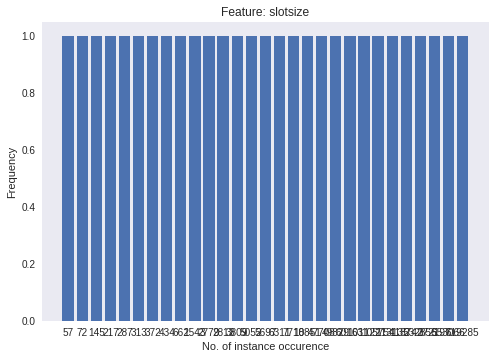

In [46]:
counts, valid_counts_index=get_frequency(data,'slotsize')

1:11337  2:3201  3:1732  4:1085  5:802  6:648  7:501  8:402  9:337  10:295  11:289  12:239  13:216  14:194  15:171  16:151  17:137  18:146  19:121  20:110  21:86  22:90  23:98  24:85  25:90  26:64  27:63  28:72  29:55  30:55  31:64  32:64  33:46  34:44  35:53  36:44  37:44  38:44  39:46  40:34  41:48  42:32  43:28  44:37  45:31  46:23  47:38  48:24  49:33  50:37  51:36  52:34  53:32  54:23  55:11  56:22  57:16  58:26  59:23  60:24  61:20  62:26  63:18  64:20  65:20  66:16  67:15  68:20  69:13  70:17  71:6  72:7  73:14  74:19  75:11  76:11  77:24  78:15  79:14  80:15  81:6  82:13  83:15  84:9  85:14  86:12  87:18  88:11  89:7  90:8  91:14  92:13  93:18  94:12  95:6  96:12  97:14  98:7  99:16  100:7  101:10  102:9  103:6  104:3  105:12  106:7  107:6  108:5  109:9  110:9  111:7  112:11  113:16  114:9  115:14  116:12  117:8  118:7  119:7  120:9  121:9  122:7  123:6  124:5  125:13  126:6  127:4  128:9  129:10  130:10  131:7  132:7  133:7  134:7  135:7  136:8  137:2  138:6  139:6  140:4  141

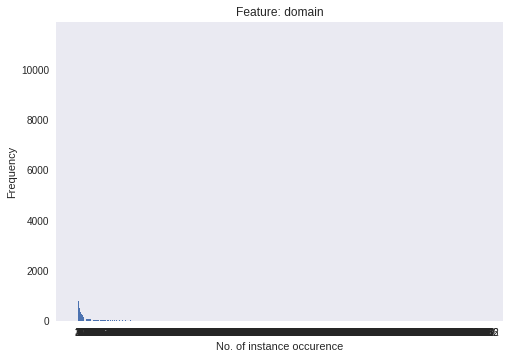

In [29]:
counts, valid_counts_index=get_frequency(data,'domain')

In [51]:
np.sum(np.asarray(counts[-5:])*np.asarray(valid_counts_index[-5:]))

1896146

In [50]:
len(counts[-10:])

10

In [0]:
dic={}
for column in data.columns:
  if not ('usertag' in column or 'click' in column or 'payprice' in column):
    for item in sorted(list(set(data[column]))):
      if not (item==-1 or item=='Na'):
        if column in ['domain','slotid1','slotid2']:
          dic[column+'_'+str(item)]=False
        else:
          dic[column+'_'+str(item)]=True
  elif 'usertag' in column:
    dic[column]=True
print('Total unique feature instances:',len(dic.keys()))

Total unique feature instances: 1663


In [0]:
data.slotprice=np.ceil(np.minimum(data.slotprice,210)/10).astype(int)
data.payprice=np.ceil(np.minimum(data.payprice,300)/10).astype(int)

In [0]:
data['new1']=''
data['new2']=''
for i in range(len(data)):
  data.at[i,'new1']=' '.join(data.loc[i,['creative','slotsize']])
  data.at[i,'new2']=' '.join(data.loc[i,['slotformat','slotvisibility']])

In [52]:
co=cooccurence_matrix(data,'adexchange','sector')
# plt.figure(
# ax2 = sns.heatmap(co)

adexchange has 5 unique instances
sector has 29 unique instances


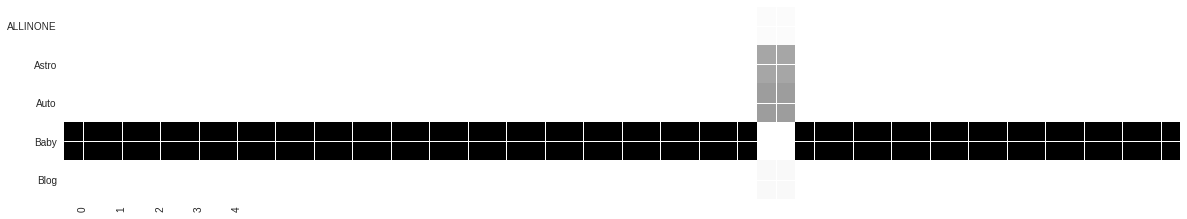

In [53]:
plt.figure(figsize=(20,20))
plt.imshow(co/np.sum(co,axis=0))
_=plt.xticks(range(co.shape[1]),sorted(set(data.adexchange)),rotation='vertical')
_=plt.yticks(range(co.shape[0]),sorted(set(data.sector)),rotation='horizontal')

In [28]:
np.sum(co[:,3])

72

In [17]:
np.expand_dims(co[1]/np.sum(co,axis=0),axis=0)

array([[0.00075036, 0.00051881, 0.00037133, 0.01388889, 0.00069057,
        0.        , 0.        , 0.00018284, 0.        , 0.        ,
        0.0003182 , 0.        , 0.00082837, 0.00460829, 0.        ,
        0.00435489, 0.00058835, 0.00105014, 0.00046114, 0.00079177,
        0.00035984, 0.00061258, 0.        , 0.00064809, 0.00056735,
        0.        , 0.00047467, 0.00268817, 0.        ]])

In [7]:
np.sum(co>0,axis=1)

array([ 8, 22, 23,  9,  3, 19, 11, 25, 11])

In [0]:
np.sum(co>0,axis=1)

array([   1, 1581,    1,  108,    1])

In [0]:
np.sum(co>0,axis=1)

array([  113,     1, 13668,     1,   152])

In [0]:
ord('a')>48

True

In [0]:
np.sum(co>0,axis=1)

<BarContainer object of 25 artists>

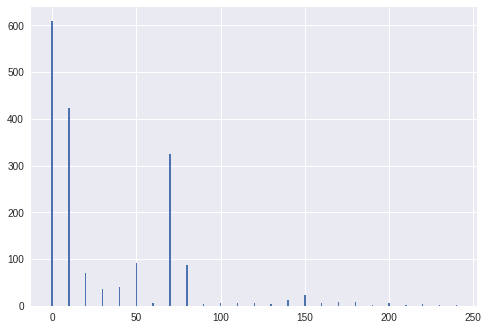

In [0]:
plt.bar(range(0,10*co2.shape[0],10),np.sum(co2,axis=1))

<BarContainer object of 30 artists>

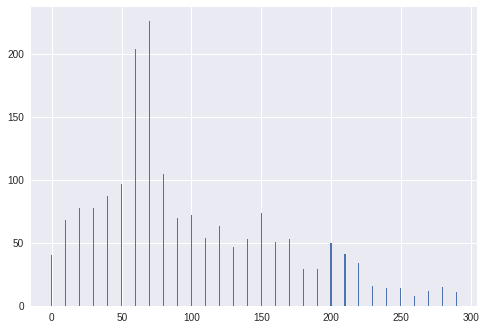

In [0]:
plt.bar(range(0,10*co2.shape[1],10),np.sum(co2,axis=0))

In [0]:
data.slotprice=np.ceil(np.minimum(data.slotprice,210)/10).astype(int)
data.payprice=np.ceil(data.payprice/10).astype(int)

In [0]:
a=np.zeros([5,3])
a[range(len(a)),[1,0,2,1,0]]=1
a

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [0]:
np.sum(co,axis=1)

array([609, 423,  71,  37,  41,  92,   7, 325,  87,   4,   7,   7,   5,
         3,  12,  24,   7,   8,   9,   2,   6,   7])

In [0]:
for i in range(len(data)):
  data.at[i,'slotprice']=np.ceil(data.at[i,'slotprice']/10).astype(int)
  data.at[i,'payprice']=np.ceil(data.at[i,'payprice']/10).astype(int)
payprice=np.zeros([len(data),len(set(data.payprice))+2]).astype(bool)
payprice[range(len(payprice)),data.payprice]=1

In [0]:
data=pd.read_csv('data2/train.csv')

In [0]:
positive_data=data.iloc[np.nonzero(data.click==1)[0]]

1:1153  2:71  3:20  4:9  5:6  6:3  7:2  9:1  10:1  13:1  17:1  25:1


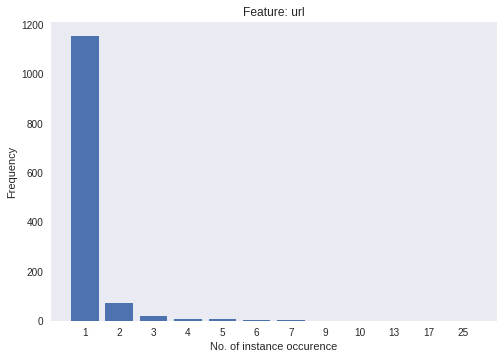

In [0]:
counts, valid_counts_index=get_frequency(positive_data,'url')

In [0]:
basic_EDA(positive_data)

field name		#int		#float		#string		#bool		#nan		#total		#unique		examples
click         		1793		0		0		0		0		1793		1		1
weekday       		1793		0		0		0		0		1793		7		0|1|2|3|4|5|6
hour          		1793		0		0		0		0		1793		24		0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23
region        		1793		0		0		0		0		1793		34		0|1|2|3|15|27|40|55|65|79|80|94|106|124|134|146|164|183|201|216|238|253|275|276|298|308|325|333|344|359
city          		1793		0		0		0		0		1793		297		0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29
adexchange    		1793		0		0		0		0		1793		5		0|1|2|3|4
domain        		0		0		1793		0		0		1793		476		1094ee84b13d866cb43c94f9b986e1f5|13625cb070ffb306b425cd803c4b7ab4|142382a759a2cb2aa094f46a32ea70e2|147a01b1254b495f5bd0178e2fe66e40|148b9f3a16837c90b6cc6253fb4e9d81|16076f675c38d669d66869a5dd41aba8|16b0b4e98b15b9042345b99e42630484|173577e3f618d6d55c9c8b587ae04640|1848d7de79148673feccb4d8d5199f46|19ac916250202fbd9147d81ef73ee38f|1c7de59b397e2ef56

Total unique feature instances: 1751


weekday_0 0
weekday_1 1
weekday_2 2
weekday_3 3
weekday_4 4
weekday_5 5
weekday_6 6
hour_0 7
hour_1 8
hour_2 9
hour_3 10
hour_4 11
hour_5 12
hour_6 13
hour_7 14
hour_8 15
hour_9 16
hour_10 17
hour_11 18
hour_12 19
hour_13 20
hour_14 21
hour_15 22
hour_16 23
hour_17 24
hour_18 25
hour_19 26
hour_20 27
hour_21 28
hour_22 29
hour_23 30
region_0 31
region_1 32
region_2 33
region_3 34
region_15 35
region_27 36
region_40 37
region_55 38
region_65 39
region_79 40
region_80 41
region_94 42
region_106 43
region_124 44
region_134 45
region_146 46
region_164 47
region_183 48
region_201 49
region_216 50
region_238 51
region_253 52
region_275 53
region_276 54
region_298 55
region_308 56
region_325 57
region_333 58
region_344 59
region_359 60
region_368 61
region_374 62
region_393 63
region_394 64
city_0 65
city_1 66
city_2 67
city_3 68
city_4 69
city_5 70
city_6 71
city_7 72
city_8 73
city_9 74
city_10 75
city_11 76
city_12 77
city_13 78
city_14 79
city_15 80
city_16 81
city_17 82
city_18 83
city_1